# Replication script for the paper "Evaluating coverage and fault detection capability of scenario-based validation of Asmeta specifications"

This script is used to replicate the results of the analyses presented in the paper.

## Data preparation


In [39]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading the necessary data

We read the file `data.csv` that contains the results of the test generation process with the three approaches: **atgt**, and **evoavalla**, and **random**.

We have two configuration for **random** generation:
- **iterative-random**: progressively increases the number of scenarios and steps until no further improvement is observed in either coverage or mutation score
- **random4atgt**: uses the same number of scenarios and steps as those generated by **atgt**

In [40]:
data = f'data.csv'
model_list_file = f'model_list.txt'
model_list_atgt_valid_file = f'model_list_atgt_valid.txt'

# Read models and valid models for atgt from lists
with open(model_list_file, 'r') as file:
    model_list = [line.strip().replace("\\","/") for line in file.readlines() if line.strip() and not line.lstrip().startswith("//")]
with open(model_list_atgt_valid_file, 'r') as file:
    model_list_atgt_valid = [line.strip().replace("\\","/") for line in file.readlines() if line.strip() and not line.lstrip().startswith("//")]

# Read and filter data, preparing a main df and a df for t test analysis on scenario length
df = pd.read_csv(data, sep=',')
df['asm_path'] = df['asm_path'].str.replace('../../../asm_examples/', '', regex=False)

# Columns of interest
mut_cols = [
    "casemutator_score",
    "chooserulemutator_score",
    "condnegator_score",
    "condremover_score",
    "forallmutator_score",
    "partoseqmutator_score",
    "seqtoparmutator_score",
    "ruleremover_score",
]
cov_cols = [
    "macro_coverage",
    "update_rule_coverage",
    "forall_rule_coverage",
    "branch_coverage",
    "rule_coverage",
]

# Ensure coverage and mutation score columns are numeric (floats). Invalid values become NaN.
for c in cov_cols + mut_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only rows of asms in the list
df = df[df['asm_path'].isin(model_list)]

# Keep only rows wit OK status
df = df[df['status'] == "OK"]

# Keep only rows where approach is 'atgt' or 'random4atgt' and in the list of atgt valid models
df_t_test = df[df['approach'].isin(['random4atgt', 'atgt'])]
df_t_test = df_t_test[df_t_test['asm_path'].isin(model_list_atgt_valid)]

# Exclude rows where approach is 'random' from main df
df = df[df['approach'] != 'random4atgt']

print("Main dataframe shape: ", df.shape)
print("Paired t-test dataframe shape: ", df_t_test.shape)

Main dataframe shape:  (273, 29)
Paired t-test dataframe shape:  (102, 29)


## RQ1 and RQ2: coverage - mutation score correlation

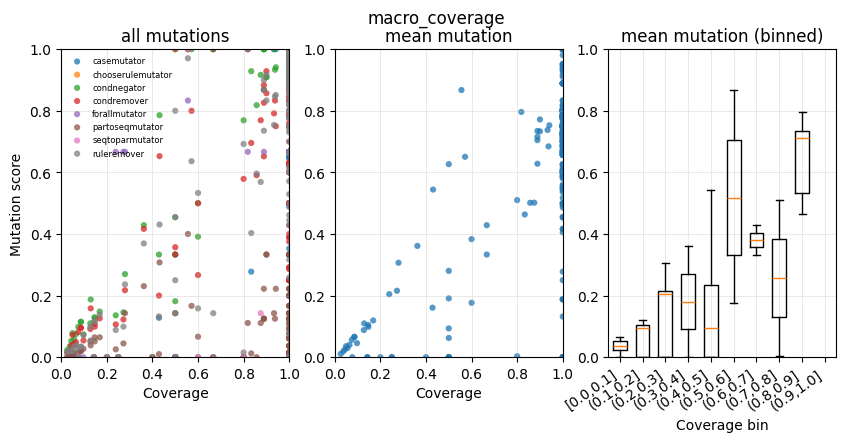

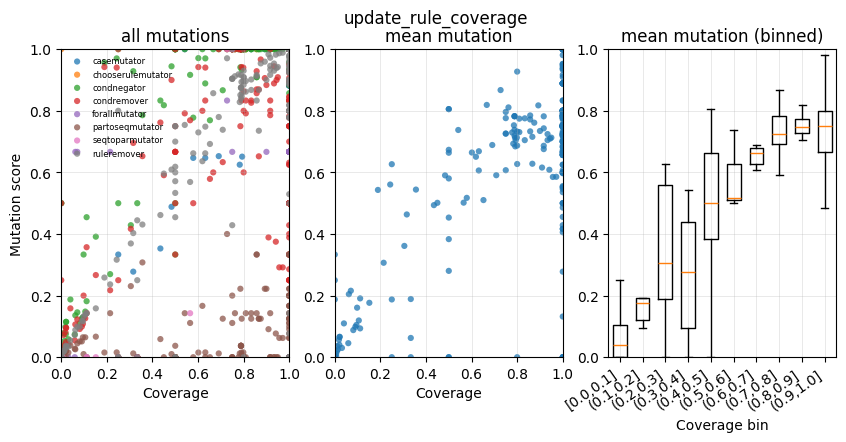

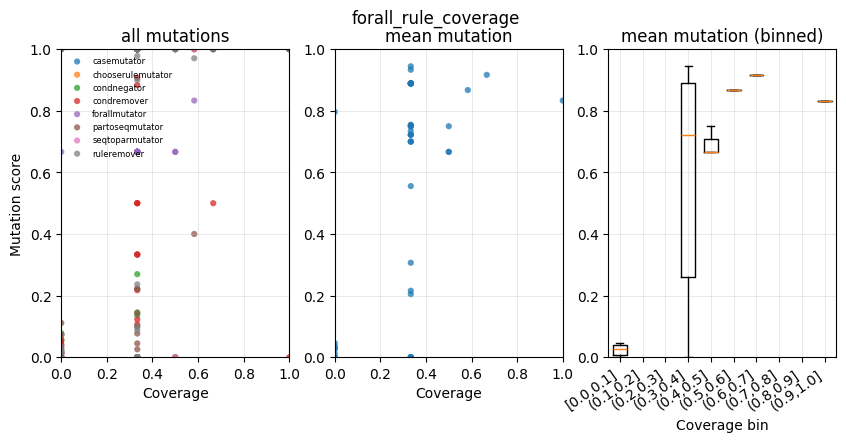

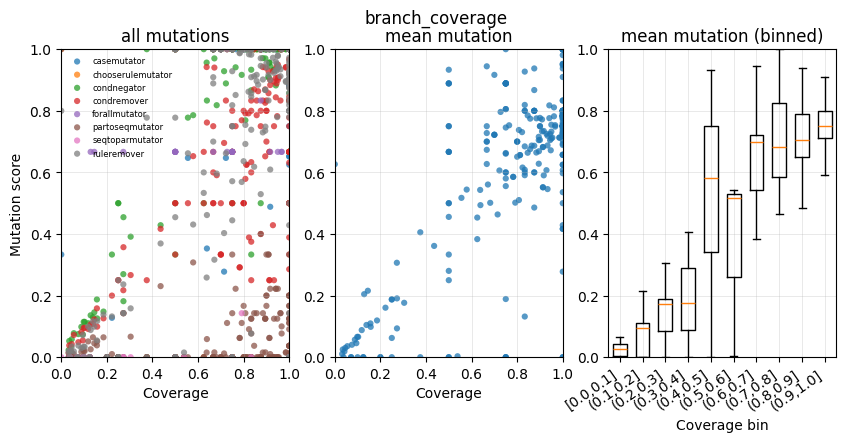

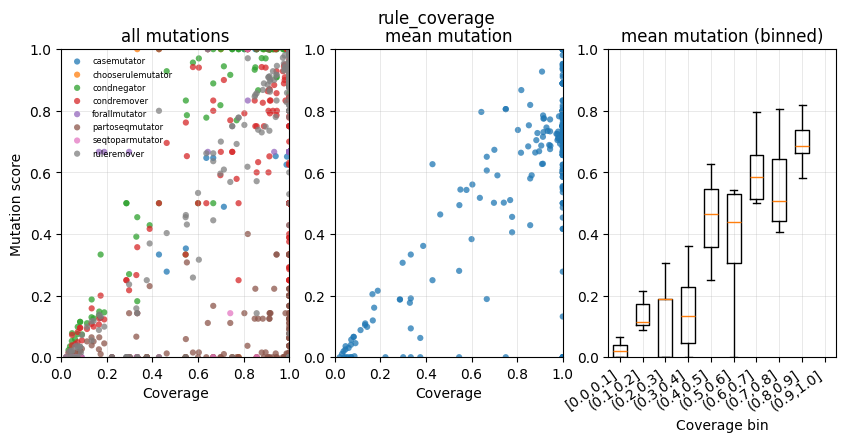

In [41]:
# Aggregate mutation score per row using mean (skip NaNs)
df["agg_mut_mean"] = df[mut_cols].mean(axis=1, skipna=True)

for cov in cov_cols:
    # skip if coverage col missing or entirely NaN
    if cov not in df.columns or df[cov].notna().sum() == 0:
        continue

    x = df[cov]        # Series (one value per row)
    y = df[mut_cols]   # DataFrame (N rows, 8 mutation-operator cols)
    n_mut = len(mut_cols)

    # Repeat x for each mutation value (row-wise repetition)
    x_rep = x.loc[x.index.repeat(n_mut)].reset_index(drop=True)

    # Flatten y row-wise to match x_rep
    y_rep = y.to_numpy().reshape(-1)

    # Labels for each point
    mut_labels = np.tile(mut_cols, len(df))

    # 3 plots side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    # Reduce whitespace between suptitle and subplot titles
    fig.suptitle(f"{cov}")

    # ---- Plot 1: all mutations colored by operator ----
    x_rep_np = x_rep.to_numpy()

    for mut in mut_cols:
        mask = (mut_labels == mut)
        axes[0].scatter(
            x_rep_np[mask],
            y_rep[mask],
            s=20,
            alpha=0.75,
            edgecolors="none",
            label=mut.replace("_score", "")
        )

    axes[0].set_title("all mutations")
    axes[0].set_xlabel("Coverage")
    axes[0].set_ylabel("Mutation score")
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, linewidth=0.5, alpha=0.4)
    axes[0].legend(fontsize=6, frameon=False, loc="upper left")

    # ---- Plot 2: aggregated mean mutation per row ----
    axes[1].scatter(
        x,
        df["agg_mut_mean"],
        s=20,
        alpha=0.75,
        edgecolors="none"
    )
    axes[1].set_title("mean mutation")
    axes[1].set_xlabel("Coverage")
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, linewidth=0.5, alpha=0.4)

    # ---- Plot 3: binned boxplot (10 bins) of coverage vs mean mutation ----
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)

    bins = pd.cut(x, bins=bin_edges, include_lowest=True)

    box_data = [
        df.loc[bins == b, "agg_mut_mean"].values
        for b in bins.cat.categories
    ]

    bp = axes[2].boxplot(
        box_data,
        widths=0.6,
        showfliers=False,
    )

    axes[2].set_title("mean mutation (binned)")
    axes[2].set_xlabel("Coverage bin")
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, linewidth=0.5, alpha=0.4)

    axes[2].set_xticks(range(1, n_bins + 1))
    axes[2].set_xticklabels(
        [
            f"[{0.0:.1f},{b.right:.1f}]" if i == 0
            else f"({b.left:.1f},{b.right:.1f}]"
            for i, b in enumerate(bins.cat.categories)
        ],
        rotation=35,
        ha="right"
    )

    # Tighten spacing + reduce top margin reserved for suptitle
    plt.show()



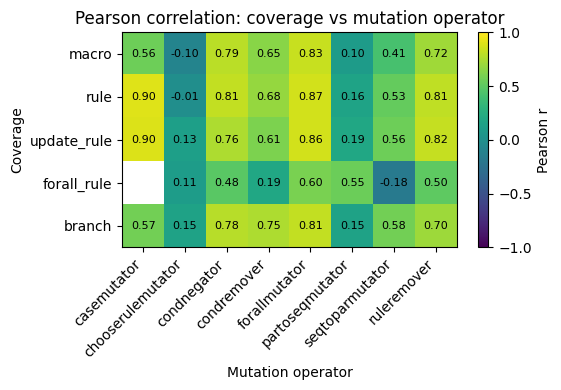

In [42]:
# --- pairwise Pearson correlation matrix: rows = coverages, cols = mutation operators ---
corr_mat = pd.DataFrame(index=cov_cols, columns=mut_cols, dtype=float)
for cov in cov_cols:
    for mut in mut_cols:
        corr_mat.loc[cov, mut] = df[[cov, mut]].corr(method="pearson").iloc[0, 1]

# Clean labels
corr_mat.columns = [c.replace("_score", "") for c in corr_mat.columns]
corr_mat.index   = [r.replace("_coverage", "") for r in corr_mat.index]

# Desired order
order = [
    "macro",
    "rule",
    "update_rule",
    "forall_rule",
    "branch",
]
corr_mat = corr_mat.loc[order]

# Plot heatmap
fig, ax = plt.subplots(
    figsize=(1.0 + 0.6 * len(corr_mat.columns), 1.5 + 0.5 * len(corr_mat.index))
)

im = ax.imshow(corr_mat.to_numpy(), vmin=-1, vmax=1, aspect="auto")

ax.set_title("Pearson correlation: coverage vs mutation operator")
ax.set_xlabel("Mutation operator")
ax.set_ylabel("Coverage")

ax.set_xticks(np.arange(len(corr_mat.columns)))
ax.set_xticklabels(corr_mat.columns, rotation=45, ha="right")

ax.set_yticks(np.arange(len(corr_mat.index)))
ax.set_yticklabels(corr_mat.index)

# Write correlation values in each cell
for i in range(corr_mat.shape[0]):
    for j in range(corr_mat.shape[1]):
        val = corr_mat.iat[i, j]
        if pd.notna(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Pearson r")

plt.tight_layout()
plt.show()